## Análisis de resultados.
En esta hoja de notas queremos comparar los resultados extraidos del DR3 de los obtenidos en el DR2 en el trabajo 
[Baumgardt et al., 2019](https://drive.google.com/file/d/1VtDW8WacV4sDh1wr_FGPmesjclg6zdbZ/view)

## Requirements

In [32]:
%load_ext autoreload
%autoreload 2


#@markdown ### Librerías y funciones auxiliares
import sys
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astroquery.vizier import Vizier
from dotenv import load_dotenv
from tqdm import tqdm
from google.cloud import storage

# Añadir el directorio raíz del proyecto al sys.path
project_path = os.path.abspath(os.path.join(os.getcwd(), "../src"))  # Subir un nivel
if project_path not in sys.path:
    sys.path.append(project_path)
            

from hyper_velocity_stars_detection.jobs.utils import read_catalog_file
from hyper_velocity_stars_detection.jobs.google_jobs.utils import load_project, ProjectDontExist

load_dotenv("../data/.env")
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../data/hvs-storage.json"
PATH = "../data/globular_clusters"
SELECTED_CLUSTERS = read_catalog_file(os.path.join(PATH, "mwgc.dat.txt"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Resultados Previos
Resultados en el DR2 en el trabajo [Baumgardt et al., 2019](https://drive.google.com/file/d/1VtDW8WacV4sDh1wr_FGPmesjclg6zdbZ/view)

In [3]:
v = Vizier(columns=["Name", "Rsun", "e_Rsun", "pmRA*", "e_pmRA*", "pmDE", "e_pmDE", "RV", "e_RV", "rho"])
v.ROW_LIMIT = -1
catalogs = v.get_catalogs("J/MNRAS/482/5138")
clusters_dr2 = catalogs[0].to_pandas()
clusters_dr2.Name = clusters_dr2.Name.str.lower()

clusters_dr2["parallax"] = 1 / (clusters_dr2.Rsun)
clusters_dr2["e_parallax"] = (1 / (clusters_dr2.Rsun - clusters_dr2.e_Rsun) - 1 / (clusters_dr2.Rsun + clusters_dr2.e_Rsun)) / 2
clusters_dr2 = clusters_dr2[["Name","parallax", "e_parallax", "pmRA_", "e_pmRA_", "pmDE", "e_pmDE", "RV", "e_RV", "rho", "Rsun", "e_Rsun"]]
clusters_dr2

,Name,parallax,e_parallax,pmRA_,e_pmRA_,pmDE,e_pmDE,RV,e_RV,rho,Rsun,e_Rsun
0,ngc 104,0.225734,0.002038,5.25,0.01,-2.53,0.01,-17.209999,0.18,0.04,4.430000,0.04
1,ngc 288,0.100200,0.003317,4.22,0.01,-5.65,0.01,-44.830002,0.13,0.31,9.980000,0.33
2,ngc 362,0.109051,0.003094,6.71,0.01,-2.51,0.01,223.259995,0.28,-0.09,9.170000,0.26
3,whiting 1,0.031949,NaN,-0.04,0.12,-1.78,0.08,-130.410004,1.79,-0.09,31.299999,NaN
4,ngc 1261,0.064558,NaN,1.61,0.02,-2.05,0.02,71.360001,0.24,0.19,15.490000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
149,ngc 7089,0.095147,0.003354,3.51,0.01,-2.16,0.01,-3.720000,0.34,0.01,10.510000,0.37
150,ngc 7099,0.125000,0.008952,-0.73,0.01,-7.24,0.01,-185.190002,0.17,0.53,8.000000,0.57
151,pal 12,0.052632,NaN,-3.28,0.03,-3.31,0.03,27.910000,0.28,0.33,19.000000,NaN
152,pal 13,0.040323,NaN,1.64,0.09,0.25,0.07,25.870001,0.27,0.04,24.799999,NaN


Extraemos la información de la relación masa luminosidad de los cluster del trabajo [McLaughlin & van der Marel, 2005](https://vizier.cds.unistra.fr/viz-bin/VizieR-3?-source=J/ApJS/161/304/table13&-out.max=50&-out.form=HTML%20Table&-out.add=_r&-out.add=_RAJ,_DEJ&-sort=_r&-oc.form=sexa)

In [4]:
catalog2= "J/ApJS/161/304/table13"
catalog1 = "J/ApJS/161/304/clusters"
catalog2= "J/ApJS/161/304/models"

v = Vizier(columns=["**"])
v.ROW_LIMIT = -1
catalogs = v.get_catalogs([catalog1, catalog2])
clusters_ml = catalogs[0].to_pandas()
tbl_2 = catalogs[1].to_pandas()

properties = ["Ltot", "Mtot", "M_L"]
for prop in properties:
    df_p = tbl_2[["Cluster", prop, f"e_{prop}", f"E_{prop}"]].sort_values(["Cluster", f"e_{prop}", f"E_{prop}"])
    clusters_ml = pd.merge(clusters_ml, df_p.groupby("Cluster").first().reset_index(), on="Cluster")

clusters_ml.SName = clusters_ml.SName.str.lower()
clusters_ml

,recno,Cluster,RAJ2000,DEJ2000,SB,M,D,SName,logAge,__Fe_H_,...,e__M_L_6,Ltot,e_Ltot,E_Ltot,Mtot,e_Mtot,E_Mtot,M_L,e_M_L,E_M_L
0,1,FORNAX1,02 37 02.1,-34 11 00,SB,M,,name fornax 1,10.11,-2.20,...,0.147,4.12,0.03,0.03,4.40,0.05,0.05,1.915,0.163,0.163
1,2,FORNAX2,02 38 40.1,-34 48 05,SB,M,,name fornax 2,10.11,-1.78,...,0.145,4.80,0.04,0.04,5.07,0.05,0.05,1.867,0.156,0.156
2,3,FORNAX3,02 39 52.5,-34 16 08,SB,M,D,name fornax 3,10.11,-1.96,...,0.145,5.13,0.04,0.04,5.40,0.05,0.05,1.880,0.159,0.159
3,4,FORNAX4,02 40 07.9,-34 32 19,SB,M,D,name fornax 4,10.06,-1.90,...,0.076,4.94,0.05,0.05,5.18,0.05,0.05,1.717,0.075,0.075
4,5,FORNAX5,02 42 21.1,-34 06 05,SB,M,D,name fornax 5,10.11,-2.20,...,0.147,4.82,0.04,0.04,5.10,0.05,0.05,1.915,0.163,0.163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,212,SMC-NGC339,00 57 48.9,-74 28 00,SB,M,,ngc 339,9.80,-1.50,...,0.117,4.87,0.05,0.06,4.90,0.07,0.07,1.088,0.104,0.104
149,213,SMC-NGC361,01 02 12.8,-71 36 16,SB,M,,ngc 361,9.91,-1.45,...,0.109,5.18,0.08,0.09,5.30,0.08,0.10,1.313,0.101,0.101
150,214,SMC-NGC411,01 07 56.0,-71 46 05,SB,M,,ngc 411,9.15,-0.68,...,0.038,4.86,0.05,0.05,4.47,0.10,0.10,0.410,0.080,0.080
151,215,SMC-NGC416,01 07 59.0,-72 21 20,SB,M,,ngc 416,9.84,-1.44,...,0.102,5.14,0.04,0.04,5.21,0.05,0.05,1.181,0.084,0.084


In [5]:
df_clusters = pd.merge(clusters_dr2, clusters_ml, left_on=["Name"], right_on="SName", how="left")
df_clusters

,Name,parallax,e_parallax,pmRA_,e_pmRA_,pmDE,e_pmDE,RV,e_RV,rho,...,e__M_L_6,Ltot,e_Ltot,E_Ltot,Mtot,e_Mtot,E_Mtot,M_L,e_M_L,E_M_L
0,ngc 104,0.225734,0.002038,5.25,0.01,-2.53,0.01,-17.209999,0.18,0.04,...,0.224,5.68,0.01,0.01,6.05,0.04,0.04,2.348,0.239,0.239
1,ngc 288,0.100200,0.003317,4.22,0.01,-5.65,0.01,-44.830002,0.13,0.31,...,0.186,4.56,0.01,0.01,4.85,0.04,0.04,1.972,0.165,0.165
2,ngc 362,0.109051,0.003094,6.71,0.01,-2.51,0.01,223.259995,0.28,-0.09,...,0.190,5.23,0.01,0.01,5.53,0.04,0.04,2.013,0.171,0.171
3,whiting 1,0.031949,NaN,-0.04,0.12,-1.78,0.08,-130.410004,1.79,-0.09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ngc 1261,0.064558,NaN,1.61,0.02,-2.05,0.02,71.360001,0.24,0.19,...,0.180,4.94,0.00,0.00,5.20,0.04,0.04,1.928,0.158,0.158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,ngc 7089,0.095147,0.003354,3.51,0.01,-2.16,0.01,-3.720000,0.34,0.01,...,0.157,5.57,0.01,0.01,5.84,0.04,0.04,1.872,0.154,0.154
150,ngc 7099,0.125000,0.008952,-0.73,0.01,-7.24,0.01,-185.190002,0.17,0.53,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
151,pal 12,0.052632,NaN,-3.28,0.03,-3.31,0.03,27.910000,0.28,0.33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
152,pal 13,0.040323,NaN,1.64,0.09,0.25,0.07,25.870001,0.27,0.04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Resultados DR3

In [329]:
CLUSTER_NAME = "ngc 6388"

cluster = [cl for cl in SELECTED_CLUSTERS if cl.name == CLUSTER_NAME][0]
project = load_project(cluster_name=cluster.name, project_id = os.getenv("PROJECT_ID"), bucket_name=os.getenv("BUCKET"),path=PATH)
print(str(project))

Las muestras analizadas de ngc 6388 son:
Muestras seleccionadas del objeto astronómico ngc 6388 con radio 1:
	 - df_1_c0 - Todas las estrellas seleccionadas: 15278.
	 - df_1_c1 - Las estrellas con errores de paralaje y pm menores al 10%: 3825.
	 - df_1_c2 - Las estrellas con un error de paralaje menor del 30% y de pm menores al 10%: 3876.
	 - df_1_c3 - Las estrellas con un error de paralaje menor del 10% y de pm menores al 20%.: 4363.

Muestras seleccionadas del objeto astronómico ngc 6388 con radio 6:
	 - df_6_c0 - Todas las estrellas seleccionadas: 39537.
	 - df_6_c1 - Las estrellas con errores de paralaje y pm menores al 10%: 3096.
	 - df_6_c2 - Las estrellas con un error de paralaje menor del 30% y de pm menores al 10%: 3127.
	 - df_6_c3 - Las estrellas con un error de paralaje menor del 10% y de pm menores al 20%.: 4223.

Se han encontrado 4 fuentes de rayos X.
Estimated number of clusters: 4
Estimated number of noise points: 14576
	 - Volumen total del cluster 0: 25.
	 - Volumen 

In [304]:
project.xsource.results

,mission,main_id,obsid,name,ra,dec,lii,bii,time,exposure,public_date,class,SEARCH_OFFSET_
0,xmmmaster,NGC_6388,146420101,NGC6388,264.08520,-44.74442,345.55392,-6.75053,52719.978171,47046.0,53110.0,LMXRB SOFT TRANSIENT,"0.747 (264.0727635845,-44.7356447628)\n"
1,xmmmaster,IGR_J17361-4441,679380301,IGR J17361-4441,264.07260,-44.73499,345.55720,-6.73795,55827.386516,41236.0,56016.0,UNIDENTIFIED,"0.040 (264.0727635845,-44.7356447628)\n"
2,chanmaster,NGC_6388,5505,NGC 6388,264.07083,-44.73500,345.55652,-6.73688,53481.102407,45160.0,53847.0,X-RAY BINARY,"0.091 (264.0727635845,-44.7356447628)\n"
3,chanmaster,NGC_6388,12453,NGC 6388,264.07292,-44.73531,345.55705,-6.73831,55802.536146,2550.0,56169.0,X-RAY BINARY,"0.021 (264.0727635845,-44.7356447628)\n"


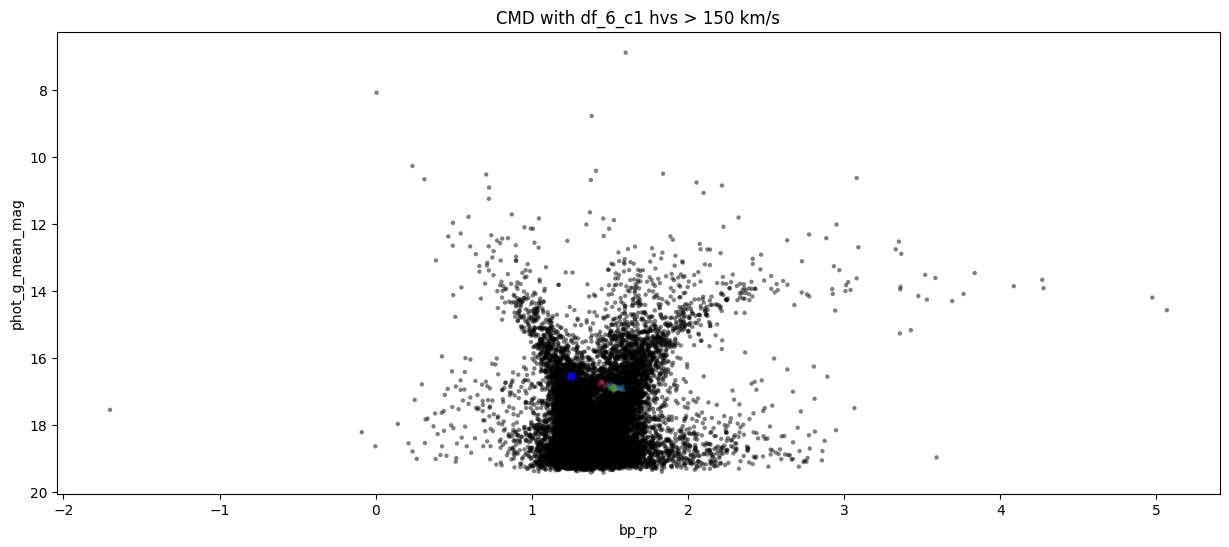

In [305]:
fig, ax = project.plot_cmd(
            hvs_candidates_name="df_6_c1",
            factor_sigma = 1,
            hvs_pm = 150,
            legend=False
)

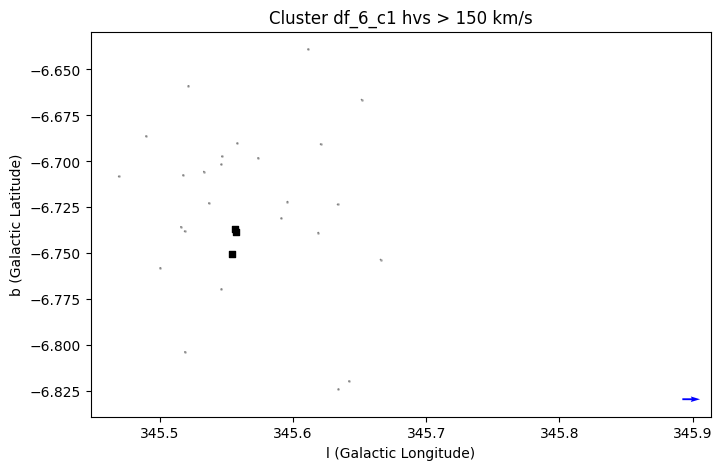

In [306]:
fig, ax = project.plot_cluster(
            hvs_candidates_name="df_6_c1",
            factor_sigma = 1,
            hvs_pm = 150,
            legend=False,
            factor_size=50
)

In [118]:
df_hvs_candidates = project.get_data("df_6_c")
selected = project.clustering_results.selected_hvs(df_hvs_candidates, 1, 150)
selected["pm_kms"] - project.clustering_results.gc.pm_kms.mean()

33      261.447138
37      594.483380
41      397.473868
48     2636.851768
51     1138.876672
53      349.634592
59     1007.886569
95      462.428756
111     327.079323
140    1054.685360
150     840.228541
Name: pm_kms, dtype: float64

In [297]:
gc = project.clustering_results.gc
display(gc[["pmra", "pmdec", "parallax", "radial_velocity"]].describe())

,pmra,pmdec,parallax,radial_velocity
count,15580.000000,15580.000000,15580.000000,231.000000
mean,-3.349489,-3.770369,0.178636,-66.489074
std,1.904395,1.819677,0.230191,49.296020
min,-8.229307,-9.626839,-0.768802,-211.413600
25%,-4.871461,-5.127091,0.047489,-80.609140
50%,-3.660539,-3.529528,0.164049,-71.419426
75%,-2.001066,-2.653370,0.318731,-62.296984
max,2.943995,2.204945,1.163581,182.746540


### Reclustering

In [325]:
columns_to_clus=["pmra", "pmdec", "parallax", 
                 'bp_rp', 
                 'phot_g_mean_mag'
                ]
data_name = "df_1_c2"

# if project.get_data(data_name).shape[0] < 16000:
#     data_name = "df_1_c0"
print("Datos seleccionados: %s" %data_name)

clustering = project.cluster_detection(
    data_name=data_name,
    columns=["pmra", "pmdec", "parallax"], 
    columns_to_clus=columns_to_clus,
    max_cluster=3,
    method="hdbscan",
    n_trials=100
)

[I 2025-05-05 01:23:32,748] A new study created in memory with name: no-name-3edae0a3-6cc5-4c07-b53a-7549d4d1dd73
[I 2025-05-05 01:23:32,830] Trial 0 finished with value: 7.555170016540382 and parameters: {'min_cluster_size': 22, 'min_samples': 4}. Best is trial 0 with value: 7.555170016540382.
[I 2025-05-05 01:23:32,917] Trial 1 finished with value: 2.1507729767003787 and parameters: {'min_cluster_size': 56, 'min_samples': 8}. Best is trial 1 with value: 2.1507729767003787.


Datos seleccionados: df_1_c2


[I 2025-05-05 01:23:33,009] Trial 2 finished with value: 4.566382548002778 and parameters: {'min_cluster_size': 50, 'min_samples': 9}. Best is trial 1 with value: 2.1507729767003787.
[I 2025-05-05 01:23:33,101] Trial 3 finished with value: 2.1507729767003787 and parameters: {'min_cluster_size': 53, 'min_samples': 8}. Best is trial 1 with value: 2.1507729767003787.
[I 2025-05-05 01:23:33,185] Trial 4 finished with value: 1000000.0 and parameters: {'min_cluster_size': 95, 'min_samples': 5}. Best is trial 1 with value: 2.1507729767003787.
[I 2025-05-05 01:23:33,275] Trial 5 finished with value: 4.495347008821038 and parameters: {'min_cluster_size': 18, 'min_samples': 8}. Best is trial 1 with value: 2.1507729767003787.
[I 2025-05-05 01:23:33,359] Trial 6 finished with value: 9.452751357976476 and parameters: {'min_cluster_size': 23, 'min_samples': 3}. Best is trial 1 with value: 2.1507729767003787.
[I 2025-05-05 01:23:33,443] Trial 7 finished with value: 0.4527944236475326 and parameters: 

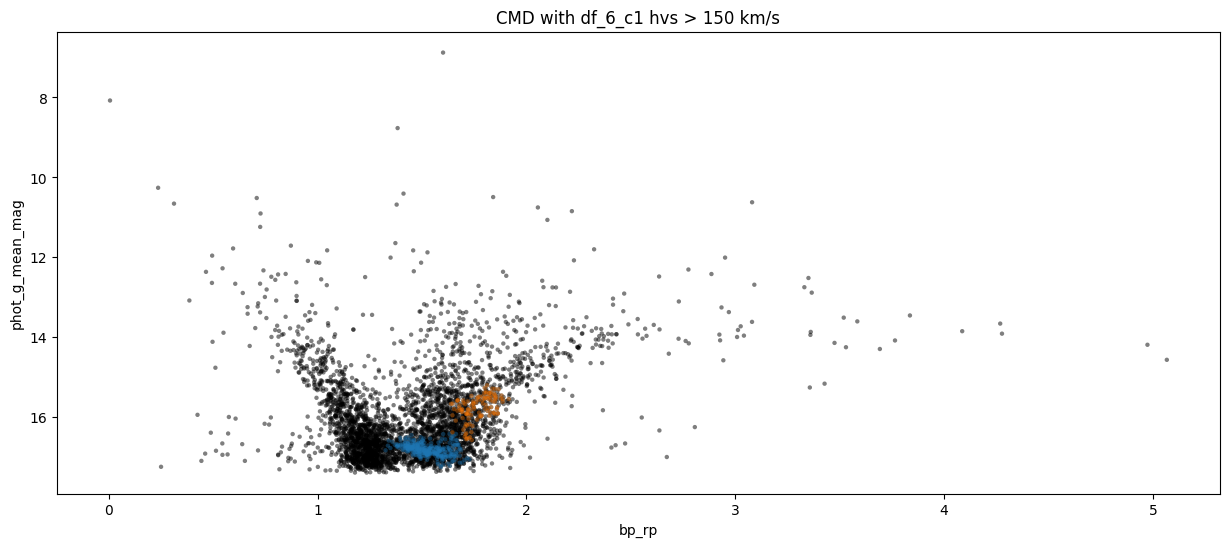

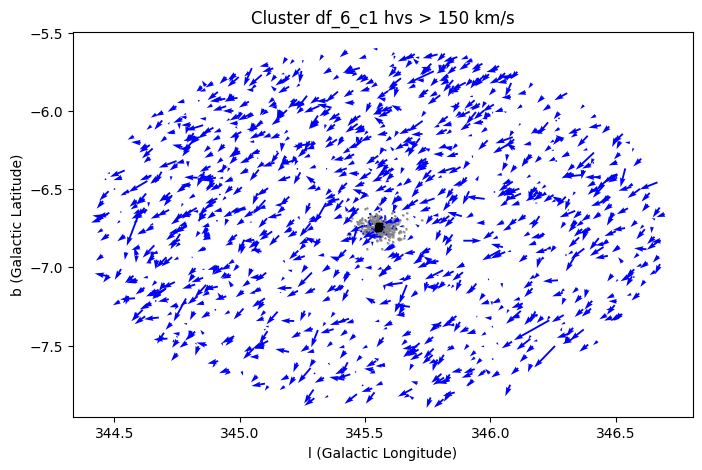

In [327]:
fig, ax = project.plot_cmd(
            hvs_candidates_name="df_6_c1",
            factor_sigma = 0,
            hvs_pm = 150,
            legend=False)

fig, ax = project.plot_cluster(
            hvs_candidates_name="df_6_c1",
            factor_sigma = 1,
            hvs_pm = 150,
            legend=False,
            factor_size=50
)

In [328]:
gc = project.clustering_results.gc
display(gc[["pmra", "pmdec", "parallax", "radial_velocity"]].describe())

,pmra,pmdec,parallax,radial_velocity
count,325.000000,325.000000,325.000000,0.0
mean,-1.346398,-2.710131,0.061603,NaN
std,0.181308,0.194613,0.087732,NaN
min,-1.825807,-3.580670,-0.170332,NaN
25%,-1.479601,-2.846556,-0.005110,NaN
50%,-1.348817,-2.709607,0.063719,NaN
75%,-1.208613,-2.581050,0.128480,NaN
max,-0.808680,-2.173328,0.303205,NaN


In [292]:
project.save_project(to_zip=True)

client = storage.Client(project=os.getenv("PROJECT_ID"))
bucket = client.bucket(os.getenv("BUCKET"))
blob_path = project.astro_object.name+".zip"
path_zip = os.path.join(project.path, blob_path)

blob = bucket.blob(blob_path)
blob.upload_from_filename(path_zip)